### Import Libraries


In [4]:
import pandas as pd
import pathlib
from joblib import load

import sys

sys.path.append("../utils")
from split_utils import get_features_data
from train_utils import get_dataset
from evaluate_utils import model_F1_score


### Load Necessary Data


In [5]:
# load features data from indexes and features dataframe
data_split_path = pathlib.Path("../1.split_data/indexes/data_split_indexes.tsv")
data_split_indexes = pd.read_csv(data_split_path, sep="\t", index_col=0)
features_dataframe_path = pathlib.Path("../0.download_data/data/labeled_data.csv.gz")
features_dataframe = get_features_data(features_dataframe_path)


### Evaluate Each Model on Each Dataset


Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: train


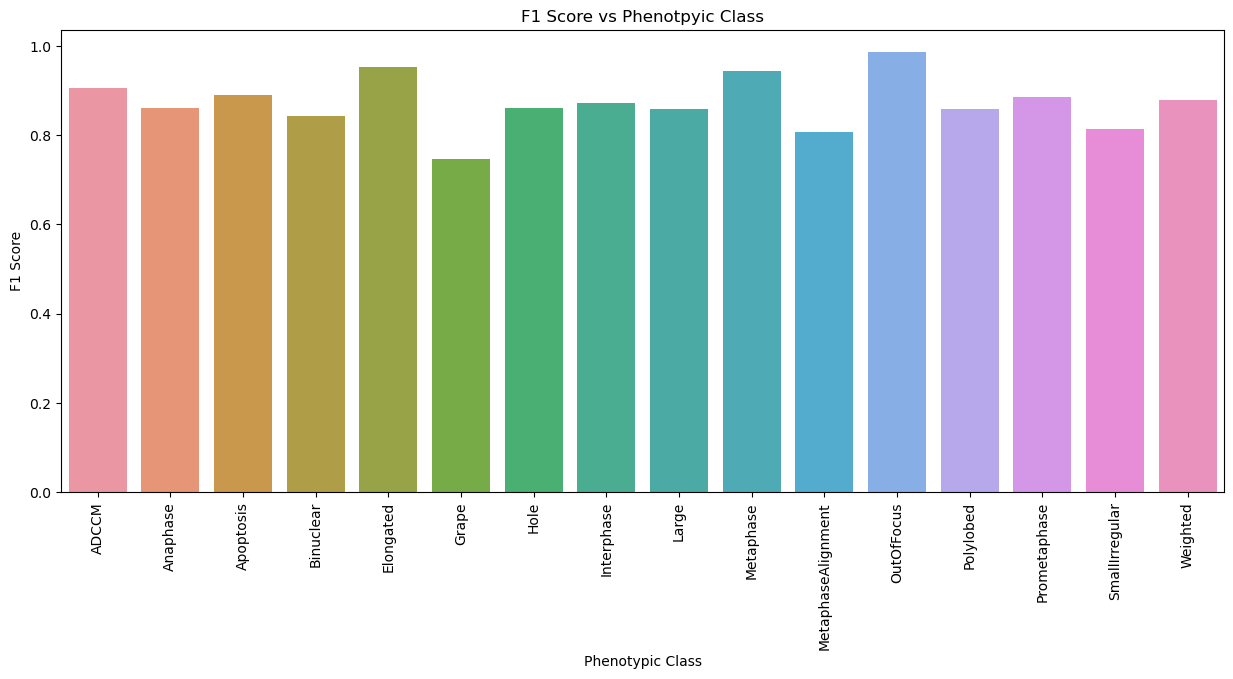

Evaluating model: final 
Trained with features: CP 
Evaluating with dataset: test


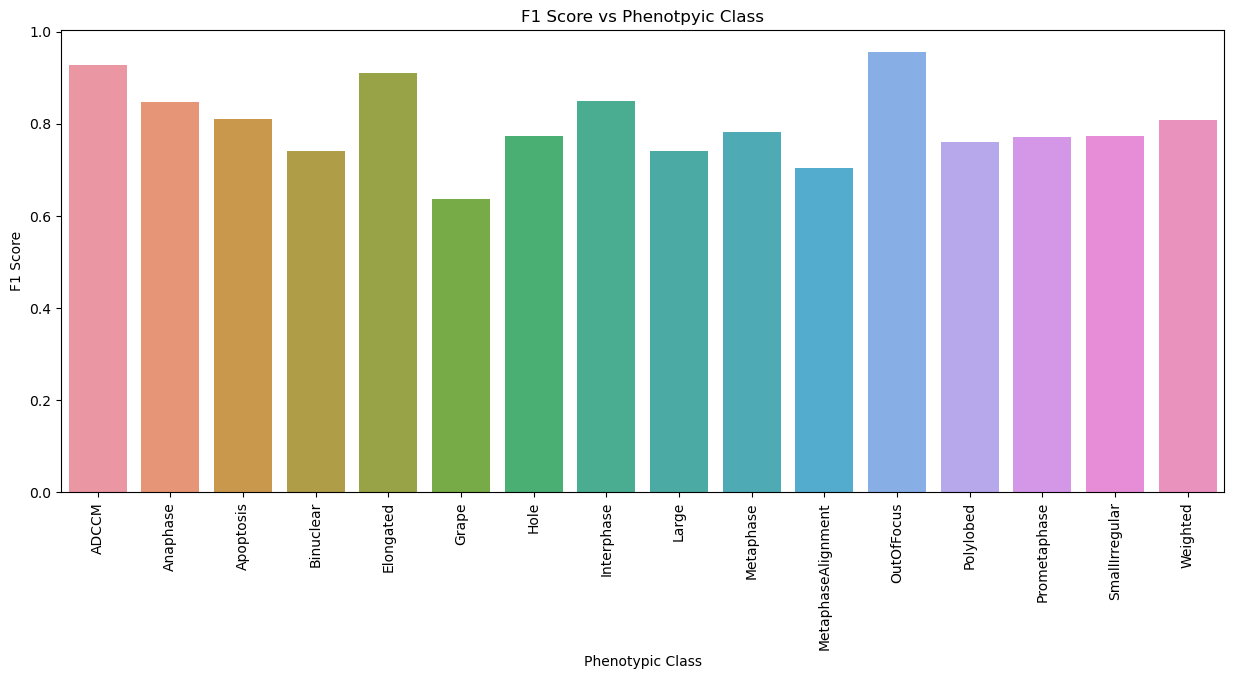

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: train


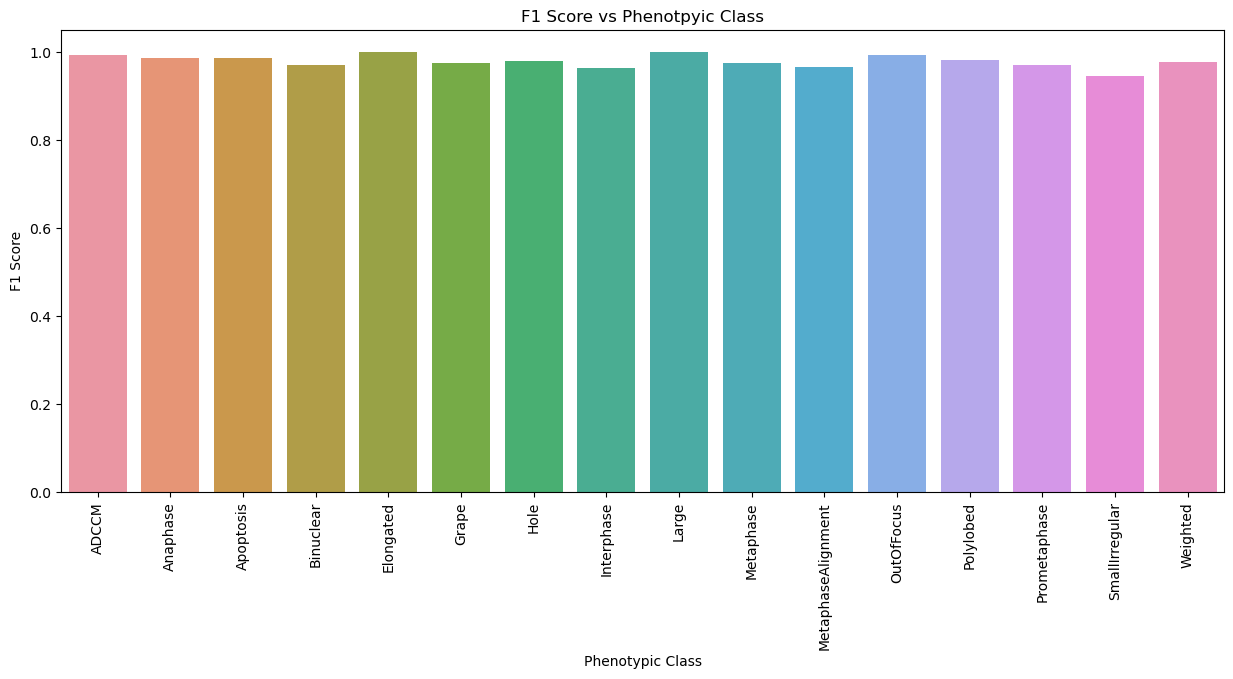

Evaluating model: final 
Trained with features: CP_and_DP 
Evaluating with dataset: test


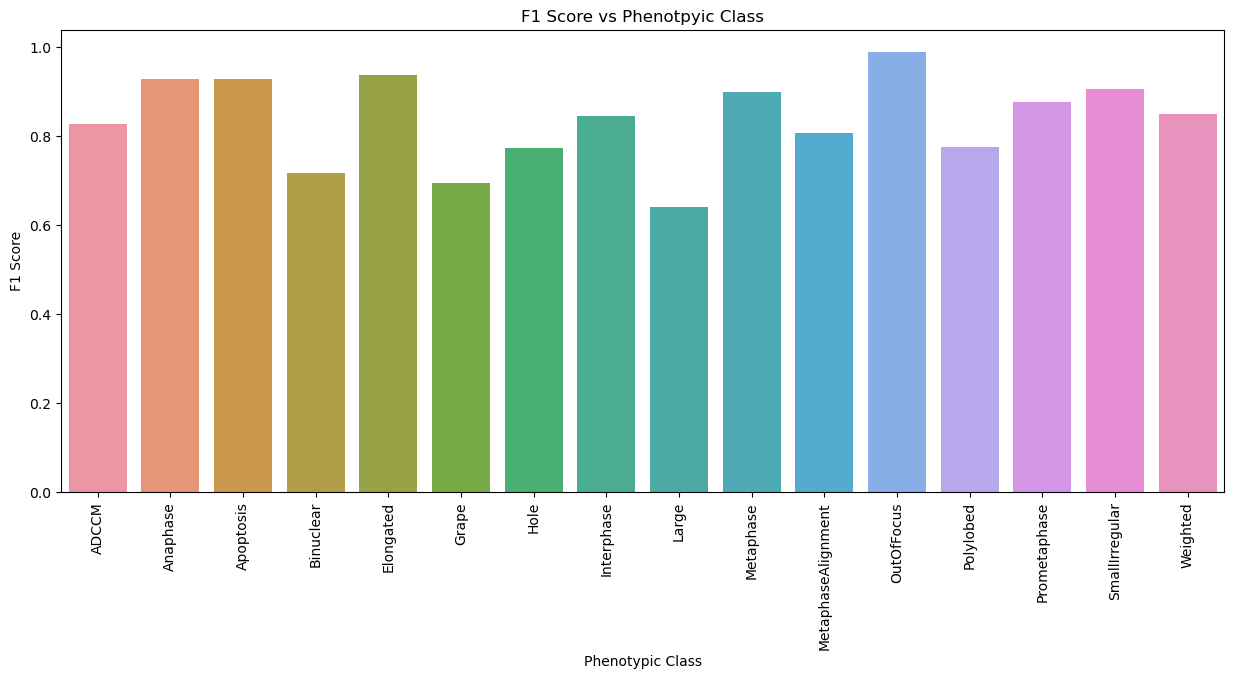

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: train


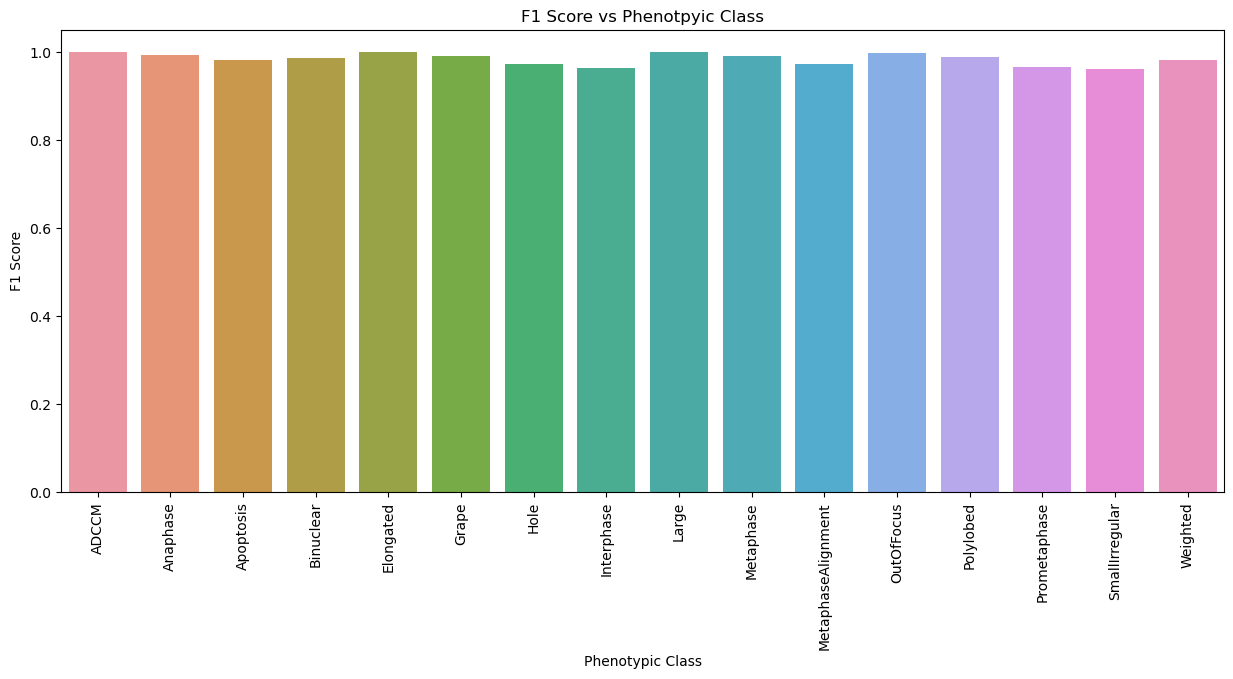

Evaluating model: final 
Trained with features: DP 
Evaluating with dataset: test


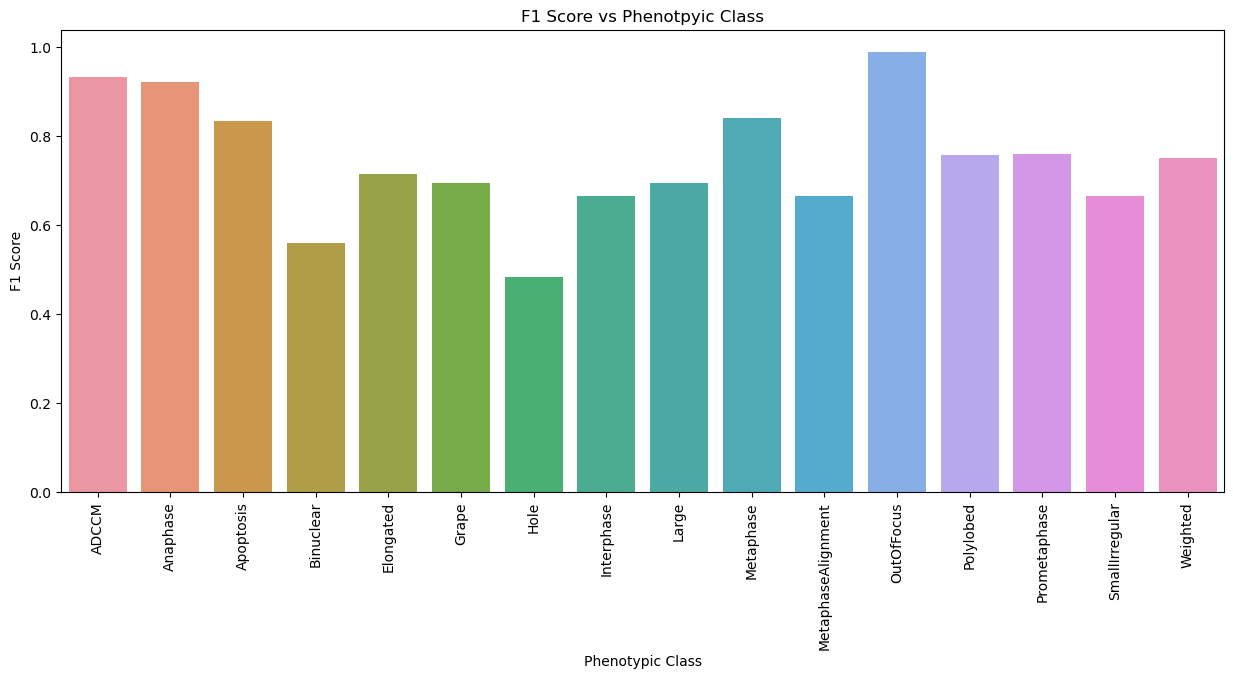

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: train


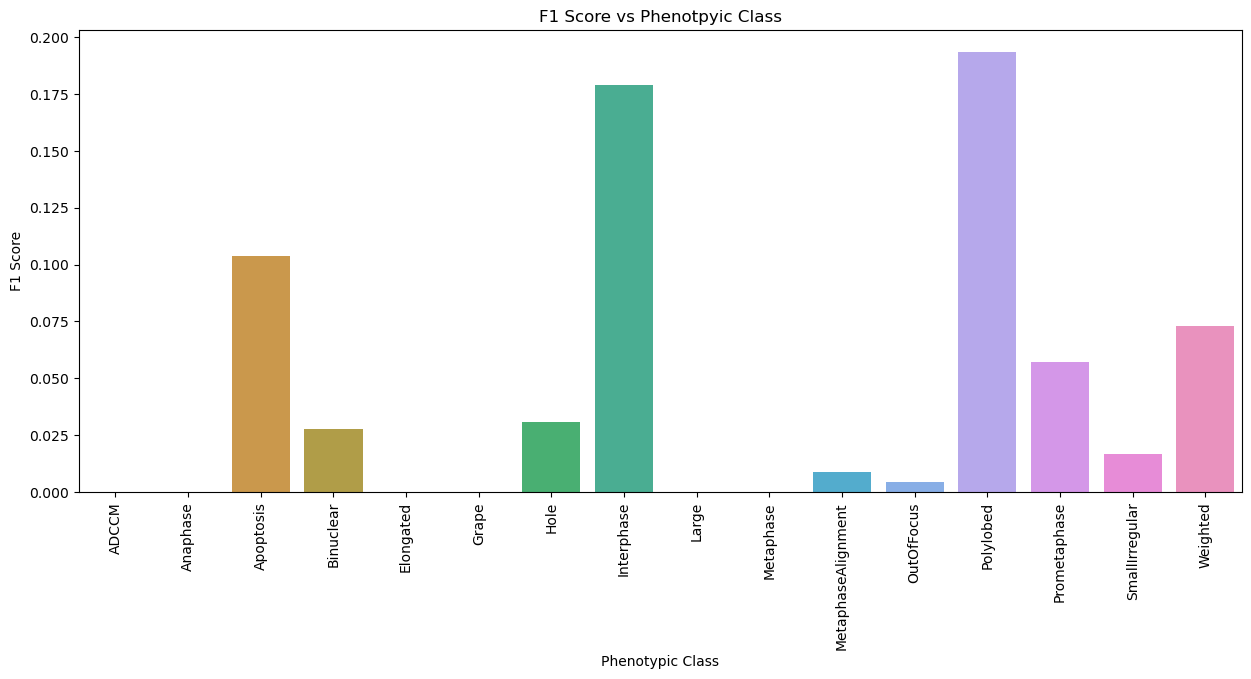

Evaluating model: shuffled_baseline 
Trained with features: CP 
Evaluating with dataset: test


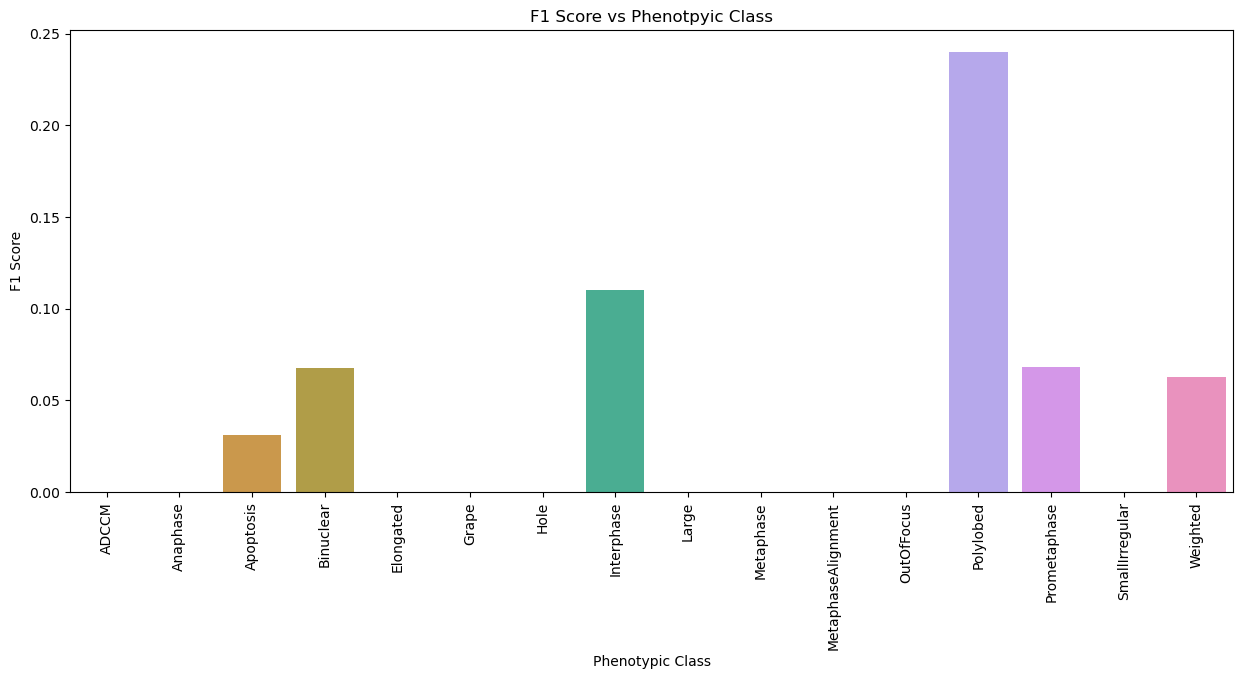

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: train


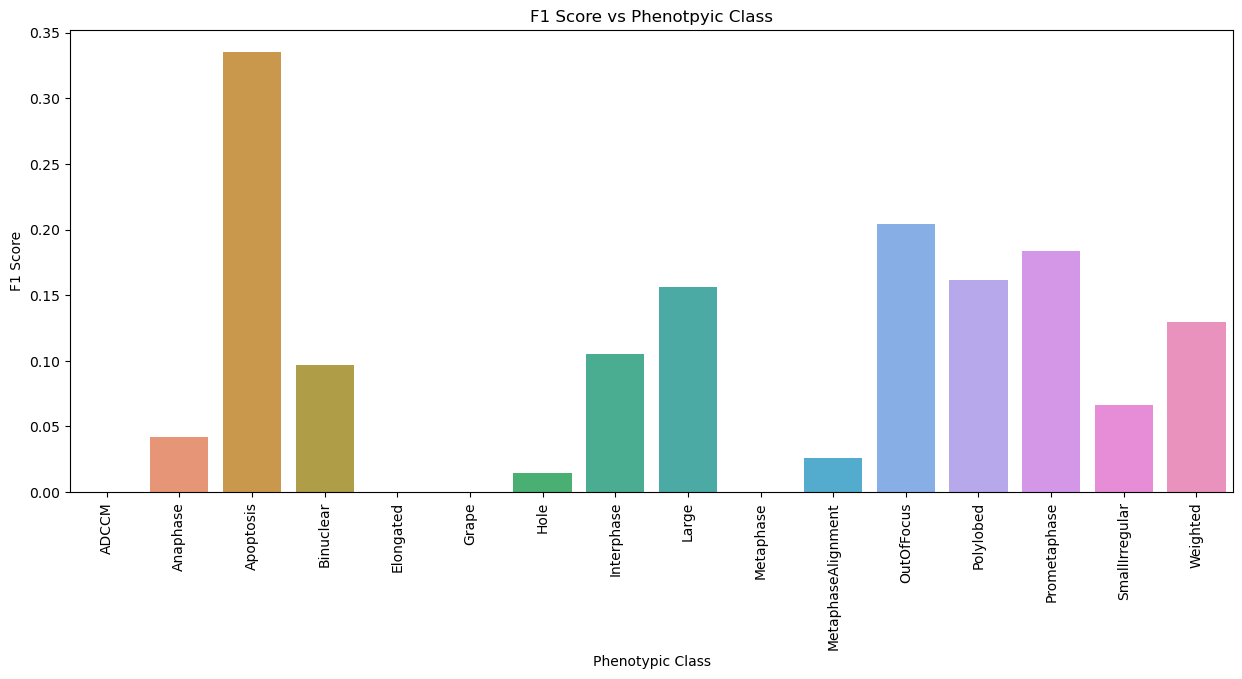

Evaluating model: shuffled_baseline 
Trained with features: CP_and_DP 
Evaluating with dataset: test


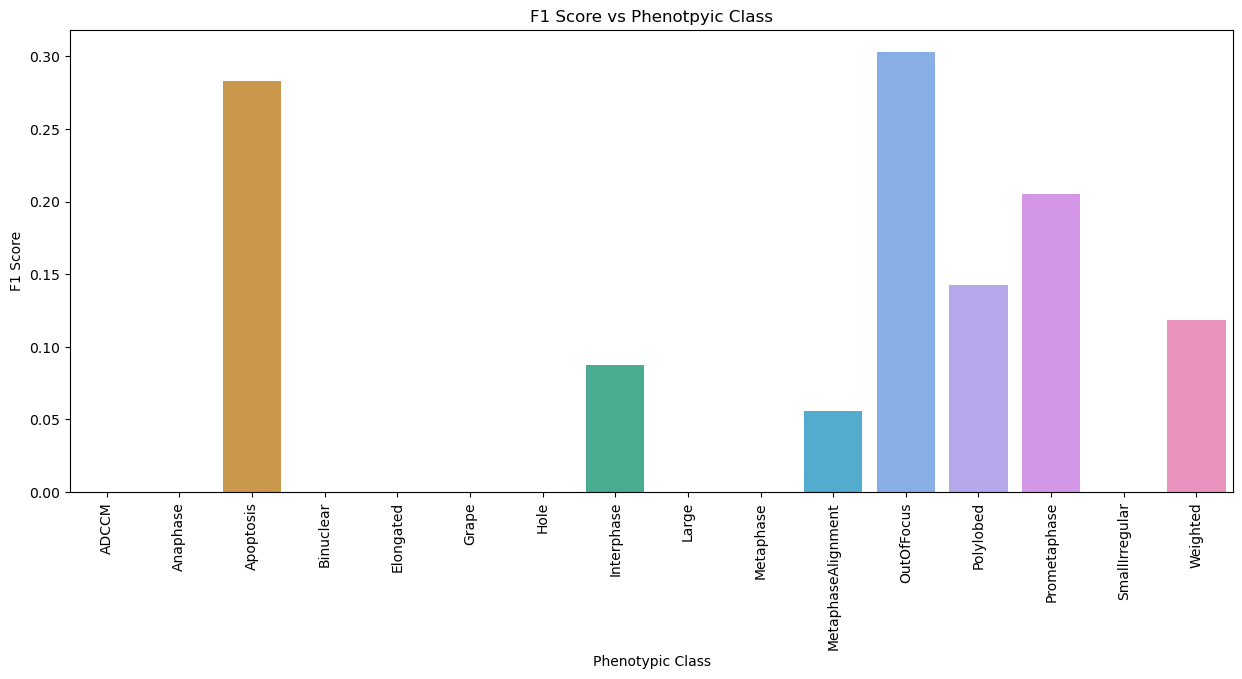

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: train


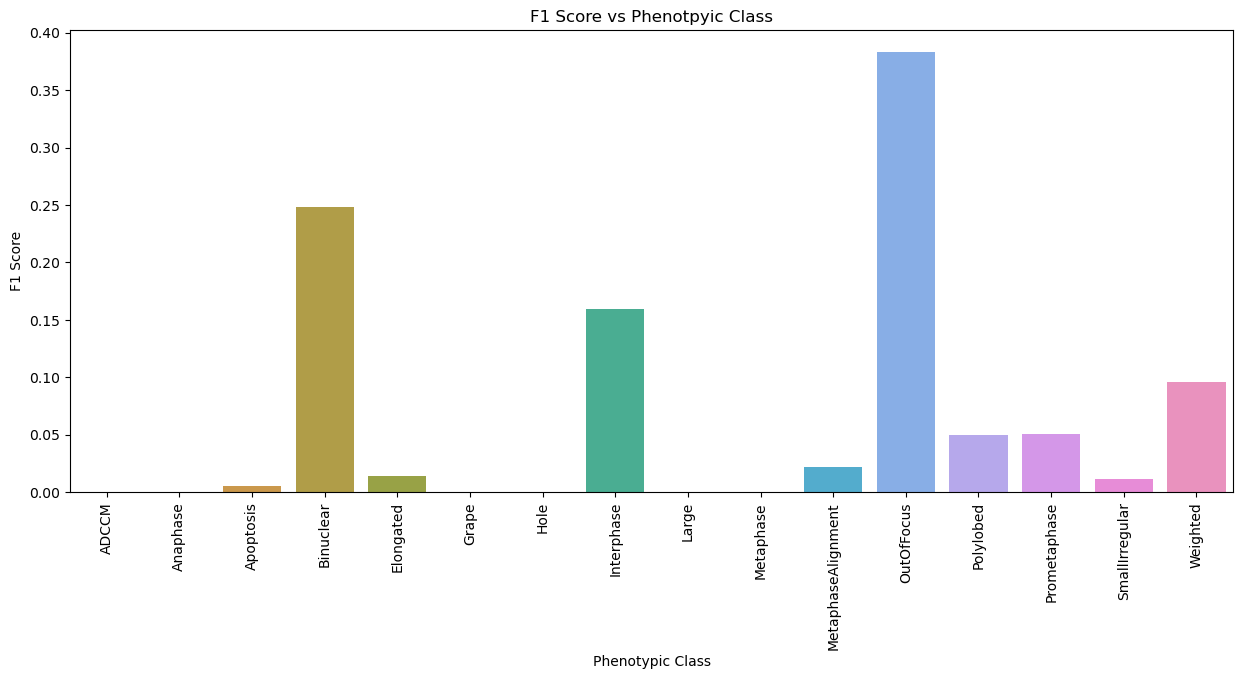

Evaluating model: shuffled_baseline 
Trained with features: DP 
Evaluating with dataset: test


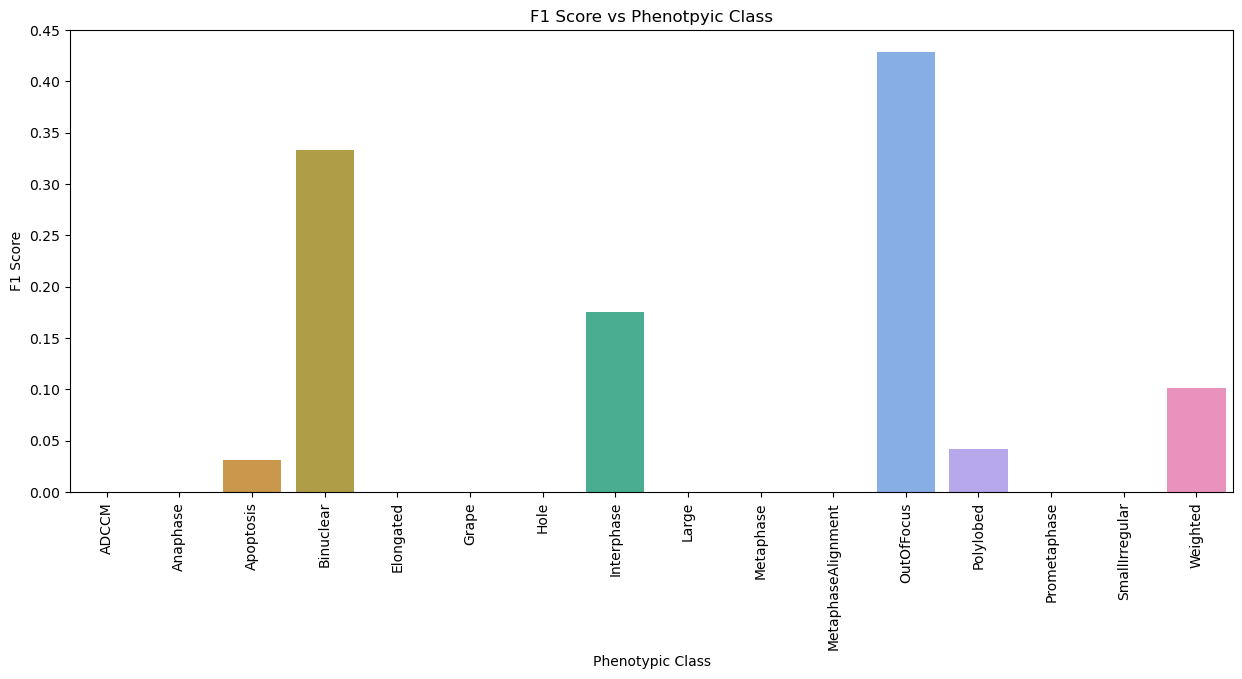

In [6]:
# directory to load the models from
models_dir = pathlib.Path("../2.train_model/models/")

# use a list to keep track of scores in tidy long format for each model and dataset combination
compiled_scores = []

# iterate through each model (final model, shuffled baseline model, etc)
# sorted so final models are shown before shuffled_baseline
for model_path in sorted(models_dir.iterdir()):
    model = load(model_path)
    # determine model/feature type from model file name
    model_type = model_path.name.split("__")[0]
    feature_type = model_path.name.split("__")[1].replace(".joblib", "")

    # iterate through label datasets (labels correspond to train, test, etc)
    # with nested for loops, we test each model on each dataset(corresponding to a label)
    for label in data_split_indexes["label"].unique():
        print(
            f"Evaluating model: {model_type} \nTrained with features: {feature_type} \nEvaluating with dataset: {label}"
        )

        # load dataset (train, test, etc)
        data = get_dataset(features_dataframe, data_split_indexes, label)
        # find model F1 scores on dataset
        score = model_F1_score(model, data, feature_type)

        # add score data to compiled dataframe in tidy format
        # transpose data and reset index to make dataframe resemble tidy long format
        score = score.T.reset_index()
        # change columns to their respective names
        score.columns = ["Phenotypic_Class", "F1_Score"]
        # add data split column to indicate which dataset scores are from (train, test, etc)
        score["data_split"] = label
        # add shuffled column to indicate if the model has been trained with shuffled data (random baseline) or not
        score["shuffled"] = "shuffled" in model_type
        # add feature type column to indicate which features model has been trained on/is using
        score["feature_type"] = feature_type

        # add this score data to the tidy scores compiling list
        compiled_scores.append(score)


### Save scores from each evaluation


In [7]:
# compile list of tidy data into one dataframe
compiled_scores = pd.concat(compiled_scores).reset_index(drop=True)

# specify results directory
f1_scores_dir = pathlib.Path("evaluations/F1_scores/")
f1_scores_dir.mkdir(parents=True, exist_ok=True)

# define save path
compiled_scores_save_path = pathlib.Path(f"{f1_scores_dir}/compiled_F1_scores.tsv")

# save data as tsv
compiled_scores.to_csv(compiled_scores_save_path, sep="\t")

# preview tidy data
compiled_scores


,Phenotypic_Class,F1_Score,data_split,shuffled,feature_type
0,ADCCM,0.905660,train,False,CP
1,Anaphase,0.861111,train,False,CP
2,Apoptosis,0.889831,train,False,CP
3,Binuclear,0.843450,train,False,CP
4,Elongated,0.952880,train,False,CP
...,...,...,...,...,...
187,OutOfFocus,0.428571,test,True,DP
188,Polylobed,0.042254,test,True,DP
189,Prometaphase,0.000000,test,True,DP
190,SmallIrregular,0.000000,test,True,DP
